In [1]:
# baseline code from: https://github.com/amirabbasii/Cartpole_C51/blob/main/C51.ipynb 

In [2]:
import torch
import gym
from torch import nn
import numpy as np
import torch.functional as F
from collections import namedtuple
import random
import math
from collections import deque
import itertools
import matplotlib.pyplot as plt

In [3]:
class Network(nn.Module):
    def __init__(self, N):                                                  
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(4, 32),                                                   # 4 features for the input
            nn.ReLU(),
            nn.Linear(32, 64),                                                   
            nn.ReLU(),
            nn.Linear(64, 128),                                                   
            nn.ReLU(),
            nn.Linear(128, 64),                                                   
            nn.ReLU(),
            nn.Linear(64, 2*N)                                                  # 2 possible actions and N supports
        )
    
        self.N = N

    def forward(self,state):
        x = self.net(state)
        return nn.Softmax(dim=2)(x.view(-1, 2, self.N)), nn.LogSoftmax(dim=2)(x.view(-1, 2, self.N))

In [4]:
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity, batch_size):
        self.capacity = capacity 
        self.memory = [] 
        self.position = 0 
        self.batch_size = batch_size 
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class Agent:
    def __init__(self, N):
        self.q = Network(N)                                                     # q = online network
        self.target = Network(N)
        self.update_target()
        self.V_min = -10
        self.V_max = 10 
        self.gamma = 0.99
        self.delta_z = (self.V_max - self.V_min) / (N - 1)
        self.optimizer = torch.optim.Adam(self.q.parameters(), lr=0.001)
        self.N = N 
        self.target_update_frequency = 10

    def action(self, state, epsilon):
        if np.random.randn() < epsilon:
            return np.random.randint(0, 2)                                      # returns 0 or 1
        
        else:
            z_distribution = torch.from_numpy(
                np.array([[self.V_min + i * self.delta_z for i in range(self.N)]])
                )
            z_distribution = torch.unsqueeze(z_distribution, 2).float()

            Q_dist, _ = self.q.forward(state)                                   # Q_dist == softmax forward output, _ == logsoftmax forward_output
            Q_dist = Q_dist.detach()
            Q_target = torch.matmul(Q_dist, z_distribution)                     # Q_target outputs 2 values. One for 'left', the other for 'right' 

            return Q_target.argmax(dim=1)[0].detach().cpu().numpy()[0]          # 0 or 1 

    def update_target(self):
        self.target.load_state_dict(self.q.state_dict())                        # target parameters <- online parameters

    def update(self, buffer):
        if len(buffer) < buffer.batch_size:
            return 
        
        batch = buffer.sample()
        batch = transition(*zip(*batch))

        batch_size = buffer.batch_size

        states = batch.state
        next_states = batch.next_state
        rewards = torch.FloatTensor(batch.reward)
        dones = torch.FloatTensor(batch.done)
        actions = batch.action
        actions = torch.tensor(actions).long()

        z_dist = torch.from_numpy( 
            np.array(
                [[self.V_min + i * self.delta_z for i in range(self.N)]] * batch_size
                ) 
            )
        z_dist = torch.unsqueeze(z_dist, 2).float()                             # there are N z-values for each batch. In total, there are 32 batches. 
                                                                                # if N==5, V_min==-2, V_max==2, then there are 5 z-values beginning from z_0(==-2) to z_4(==2)
        # print("z_dist.shape", z_dist.shape)
        # calculation of p_i(x_t, a_t). Here we use the online network
        _, Q_log_dist = self.q.forward(torch.FloatTensor(states))
        Q_log_dist = Q_log_dist[torch.arange(batch_size), actions, :]           # 'shape of Q_log_dist' == (batch_size, N). For example, shape is (32, 5)
        # print("Q_log_dist.shape", Q_log_dist.shape)

        # calculation of p_i(x_t+1, a*) using target network
        Q_next_target_dist, _ = self.target.forward(torch.FloatTensor(next_states))
        # print("Q_next_target_dist.shape", Q_next_target_dist.shape)

        Q_target = torch.matmul(Q_next_target_dist, z_dist).squeeze(1)
        # print("Q_target.shape", Q_target.shape)

        max_Q_next_target= Q_next_target_dist[torch.arange(batch_size), torch.argmax(Q_target, dim=1).squeeze(1), :]
        # print("max_Q_next_target.shape", max_Q_next_target.shape)

        # print("--------------------------------------------------------------")

        m = torch.zeros(batch_size, self.N)
        for j in range(self.N):

            T_zj = torch.clamp(rewards + self.gamma * (1 - dones) * (self.V_min + j * self.delta_z), min = self.V_min, max = self.V_max)   
            bj = (T_zj - self.V_min) / self.delta_z
            l = bj.floor().long()
            u = bj.ceil().long()

            Q_l = torch.zeros(m.size())
            Q_l.scatter_( 1, l.reshape( (batch_size,1) ), max_Q_next_target[:,j].unsqueeze(1) * (u.float() - bj.float()).unsqueeze(1) )
            Q_u = torch.zeros(m.size())
            Q_u.scatter_( 1, u.reshape( (batch_size,1) ), max_Q_next_target[:,j].unsqueeze(1) * (bj.float() - l.float()).unsqueeze(1) )
            m = m + Q_l
            m = m + Q_u

        self.optimizer.zero_grad()
        loss = - torch.sum( torch.sum( torch.mul(Q_log_dist, m), -1 ), -1 ) / batch_size

        loss.backward()
        self.optimizer.step()
        self.target_update_frequency += 1

        #updating target network
        if (self.target_update_frequency == 100):
            self.update_target()
            self.target_update_frequency = 0

In [6]:
def analysis_tool(number_of_atoms):

    EPISODES = 500
    BATCH_SIZE = 64 
    ENV = gym.make("CartPole-v1")
    REWARD_BUFFER = deque([0.0], maxlen=100)
    MEMORY_BUFFER = ReplayMemory(10000, BATCH_SIZE)  
    REWARDS = list()
    AGENT = Agent(number_of_atoms)    
    
    EPSILON_START = 0.5
    EPSILON_END = 0.0
    EPSILON_DECAY = EPISODES // 2

    for EPISODE in range(EPISODES):
        
        epsilon = np.interp(EPISODE, [0, EPSILON_DECAY], [EPSILON_START, EPSILON_END])

        print(f"Episode {EPISODE} started. epsilon value is {epsilon}")
        state = ENV.reset()
        episode_reward = 0 

        for STEP in itertools.count():  

            action = AGENT.action(torch.FloatTensor([state]), epsilon)
            next_state, reward,done, _ = ENV.step(action)
            MEMORY_BUFFER.push(state, action, next_state, reward, done)
            AGENT.update(MEMORY_BUFFER)
            state = next_state
            episode_reward = episode_reward + reward

            if done:
                REWARD_BUFFER.append(episode_reward)
                REWARDS.append(np.mean(REWARD_BUFFER))
                break
        
    return REWARDS

In [ ]:
C51_REWARDS = analysis_tool(51)
C21_REWARDS = analysis_tool(21)
C11_REWARDS = analysis_tool(11)
C5_REWARDS  = analysis_tool(5)

[]

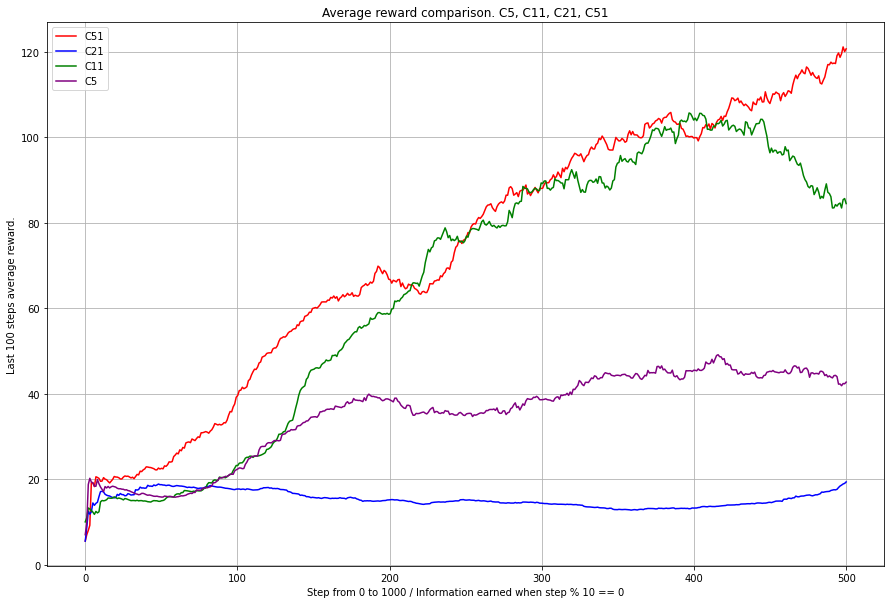

In [8]:
length = len(C51_REWARDS)

fig, ax = plt.subplots(figsize=(15, 10))

x = np.linspace(0, length, length)

ax.plot(x, C51_REWARDS, label='C51', color='red')
ax.plot(x, C21_REWARDS, label='C21', color='blue')
ax.plot(x, C11_REWARDS, label='C11', color='green')
ax.plot(x, C5_REWARDS,  label='C5',  color='purple')

ax.set_xlabel("Step from 0 to 1000 / Information earned when step % 10 == 0")
ax.set_ylabel("Last 100 steps average reward.")
ax.set_title("Average reward comparison. C5, C11, C21, C51")

ax.legend()
ax.grid()
ax.plot()